#  NLP_ENDOPATHS_transformers

Author: Nicolai Wolpert  
Email: nicolai.wolpert@capgemini.com  
Date: July 2024

Script to test BERT transformer models to predict patient symptoms from gynéco text files

## Imports

In [3]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
import re
#pd.set_option('display.max_rows', 10)
from matplotlib import pyplot as plt
import seaborn as sns

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve


# Custom preprocessing : 
from preprocess_NLP import *

from metrics_utils import *
from Opti_utils.ML_utils import Binarisation

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

import pickle

In [4]:
model_dir = '../../models/'
pred_dir = '../../predictions/'

# Choose pretrained model to use (e.g. 'camembert-base' or 'camembert/camembert-large')
pretrained_model = 'camembert-base'

## Load data

In [10]:
target_feature = 'atcd.endo'

# Loading X : 
df_nlp = pd.read_csv('./../../Data/Generate/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
df_nlp_orig = df_nlp.copy()
print('X shape is :', df_nlp.shape)

# Loading Y : 
recueil_orig  = pd.read_excel('./../../Data/Raw/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil = recueil_orig.copy()
recueil = recueil[['Numéro anonymat', 'atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']]
recueil.replace(['Na', 'NA'], np.nan, inplace=True)
recueil = recueil.rename(columns={'Numéro anonymat': 'Anonymisation'})
# Note the target variable, if endometriosis is present or not (corresponds to the anapth columns but not 'autre')
recueil['endometriose'] = recueil_orig.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
# Drop the anapath columns again
recueil = recueil[[c for c in recueil.columns if not c.startswith('anapath')]]
recueil = recueil[['Anonymisation'] + [target_feature]]

# Read the receuil version created by manually extracting infos from gyneco files
receuil_manual = pd.read_excel('./../../Data/Generate/data_gynéco_manual_extraction.xlsx')
receuil_manual = receuil_manual[['Anonymisation'] + [target_feature]]

print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')
print(f'Nombre de patientes dans le recueil : {len(recueil.Anonymisation.unique())}')
npatients_in_gyneco_and_receuil = len(set(df_nlp.Anonymisation.unique()).intersection(set(recueil.Anonymisation.unique())))
print(f'Nombre de patientes dans gyneco et recueil : {npatients_in_gyneco_and_receuil}')
num_labels = len(pd.unique(recueil[target_feature]))
print(f'Nombre de classes pour{target_feature}: {num_labels}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

X shape is : (1137, 4)
Y shape is : (181, 2)
Nombre de patientes dans le df_nlp : 178
Nombre de patientes dans le recueil : 181
Nombre de patientes dans gyneco et recueil : 156
Nombre de classes pouratcd.endo: 2


False

## Preprocessing

In [13]:
# IMPORTANT: Lowercase and removal of special characters has to be applied before 'correction_series', else words will not be found in the correction dictionnary
df_nlp.Résumé = df_nlp.Résumé.apply(remove_special_characters)
df_nlp.Résumé = df_nlp.Résumé.apply(lowercase_text)
df_nlp.Résumé = df_nlp.Résumé.apply(correction_series)
df_nlp

,Anonymisation,Date,Nature,Résumé
0,AA-071,2019-12-08,Ordonnance,1 en cas d hystéroscopie avant la ménopause ...
1,AA-071,2018-10-29,Ordonnance,rectosonographie échographie pelvienne avec c...
2,AA-071,2019-09-16,Ordonnance,cerazette 1 comprimÃ© par jour sans interrup...
3,AA-071,2019-09-17,Ordonnance,mopral 20 mg 1 gélule le soir pendant 15 jou...
4,AA-071,2021-04-05,Ordonnance,dispositif intra utérin hormonal mirena 1 un...
...,...,...,...,...
1132,7423767,2020-02-17,Consultation,suites opératoires simples métror 10 15j ablat...
1133,7423767,2020-02-17,Ordonnance,seasonique oar 1 an
1134,7423767,2020-02-17,Mots,suites opératoires simples métror 10 15j ablat...
1135,7423767,2020-06-01,Ordonnance,1 en cas d hystéroscopie avant la ménopause ...


In [14]:
df_nlp.loc[3, 'Résumé']

'mopral 20 mg   1 gélule le soir pendant 15 jours  gaviscon   1 sachet matin midi et soir après les repas et éventuellement 1 au coucher pendant 15 jours  lamaline gel   la posologie usuelle est de 3 à 5 gélules par jour  à raison de 1 à 2 gélules par prise  sans dépasser 10 gélules par jour  espacer les prises de 4 heures  ne pas de passer 4g de paracétamol par jour  attention la lamaline en contient     '

### Camembert model accepts sentences with a maximum length of 512. Check lengths of our sentences

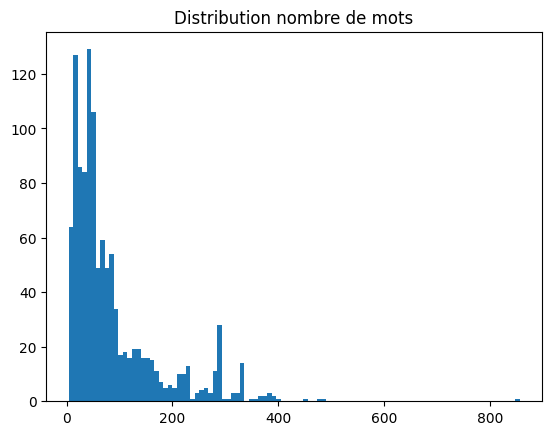

In [15]:
nwords = [len(df_nlp.loc[idx, 'Résumé'].split(' ')) for idx in df_nlp_orig.index]
plt.figure()
plt.hist(nwords, bins=100)
plt.title('Distribution nombre de mots')
plt.show()

In [17]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)
tokenized_data = tokenizer(df_nlp['Résumé'].tolist())
ntokens = [len(tokenized_data['input_ids'][i]) for i in range(len(tokenized_data['input_ids']))]
plt.figure()
plt.hist(ntokens, bins=100)
plt.axvline(x=512, color='red')
plt.title('Distribution nombre de tokens')
plt.show()

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /camembert-base/resolve/main/tokenizer_config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"), '(Request ID: 98385a65-95e6-4bc7-b946-d46541d4c0d5)')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (710 > 512). Running this sequence through the model will result in indexing errors


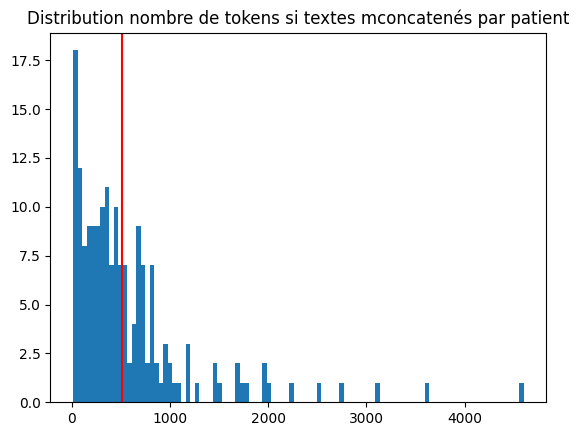

In [8]:
# Check distribution if text is concatenated across patients
df_nlp_concat = df_nlp.copy()
df_nlp_concat = df_nlp_concat.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()  # not joining all texts for patients anymore
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)
tokenized_data = tokenizer(df_nlp_concat['Résumé'].tolist())
ntokens = [len(tokenized_data['input_ids'][i]) for i in range(len(tokenized_data['input_ids']))]
plt.figure()
plt.hist(ntokens, bins=100)
plt.axvline(x=512, color='red')
plt.title('Distribution nombre de tokens si textes mconcatenés par patient')
plt.show()

## Data preparation for training

In [19]:
preprocess_mode = 'multiclass'      # 'multiclass' = garder les nan et les traiter comme classe, 'dropnan' = enlever les nan

# Merge receuil and nlp dataframes and rename columns
mean_pooling = True
if mean_pooling:
    df_nlp = df_nlp.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()
data = pd.merge(df_nlp, recueil, on='Anonymisation', how='inner')
data = data.rename(columns={'Anonymisation': 'patient', 'Résumé': 'text', target_feature: 'outcome'})
# Format labels
def label_outcome(row):
    if row['outcome'] == 0:
        return 'absent'
    elif row['outcome'] == 1:
        return 'present'
    else:
        return 'missing'
data['str_outcome'] = data.apply(label_outcome, axis=1)
### Treat missing values as class or drop them

if preprocess_mode == 'multiclass':
    data.outcome = data.outcome.fillna(2)
    data['outcome'] = data['outcome'].astype(int)
data

,patient,text,outcome,str_outcome
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,0,absent
1,AB-067,rééducation vesico périnéale pour iu mixte hyp...,0,absent
2,AC-131,difficulté post opus avec douleur abdo et ball...,0,absent
3,AE-060,appel téléphonique patiente moins douloureuse...,1,present
4,AE-062,rectosonographie échographie pelvienne avec c...,1,present
...,...,...,...,...
152,WL-197,je sous signée cuq juliette interne en médecin...,1,present
153,WM-073,1 en cas d hystéroscopie avant la ménopause ...,1,present
154,WM-089,rectosonographie échographie pelvienne avec c...,1,present
155,YC-171,dienogest comprimé à 2 mg sawis dimetrum ...,0,absent


In [20]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)

def tokenize_batch(samples, tokenizer, max_length):
    text = [sample["text"] for sample in samples]
    labels = torch.tensor([sample["outcome"] for sample in samples])
    str_labels = [sample["str_outcome"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    #tokens = tokenizer(text, padding="longest", return_tensors="pt")
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}


SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /camembert-base/resolve/main/tokenizer_config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"), '(Request ID: 0a2f8a2d-ff9f-41c2-8240-452a99d35769)')

### Train/Val/Test split

In [47]:
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1

# Choose how to split: 
# 'patientwise': On patient-level (such that no patient is in the train and val/test set)
# 'patientmix': Not seperating patients in train vs. val/test set
method_split = 'patientwise'

### Split based on patients
if method_split == 'patientwise':
    patient_outcomes = data.groupby('patient')['outcome'].max().reset_index()
    patient_outcomes['nrows'] = list(data['patient'].value_counts())

    train_patients, test_patients = train_test_split(
        patient_outcomes,
        test_size=prop_test,
        stratify=patient_outcomes['outcome'],
        random_state=42
    )

    train_patients, val_patients = train_test_split(
        train_patients,
        test_size=0.125,
        stratify=train_patients['outcome'],
        random_state=42
    )

    train = data.loc[data.patient.isin(list(train_patients.patient))]
    val = data.loc[data.patient.isin(list(val_patients.patient))]
    test = data.loc[data.patient.isin(list(test_patients.patient))]

    npatients_train = len(pd.unique(train.patient))
    npatients_val = len(pd.unique(val.patient))
    npatients_test = len(pd.unique(test.patient))

    print(f'Number of patients in train set: {npatients_train}')
    print(f'Number of patients in validation set: {npatients_val}')
    print(f'Number of patients in test set: {npatients_test}')

### Simple approach, patients mixed in train and val/test
else:
    train, test = train_test_split(data, random_state=42, test_size=prop_test, stratify=data['outcome'])
    train, val = train_test_split(train, random_state=42, test_size=0.125, stratify=train['outcome'])

    print(f'Number of samples in train set: {train.shape[0]}, = {round((train.shape[0]/data.shape[0])*100, 2)} %')
    print(f'Number of samples in validation set: {val.shape[0]}, = {round((val.shape[0]/data.shape[0])*100, 2)} %')
    print(f'Number of samples in test set: {test.shape[0]}, = {round((test.shape[0]/data.shape[0])*100, 2)} %')


Number of patients in train set: 123
Number of patients in validation set: 18
Number of patients in test set: 16


In [48]:
train

,patient,text,outcome,str_outcome
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,0.0,absent
1,AB-067,rééducation vesico périnéale pour iu mixte hyp...,0.0,absent
4,AE-062,rectosonographie échographie pelvienne avec c...,2.0,missing
6,AM-038,docteur le bail docteur gay soare ffi bien...,1.0,present
7,AM-172,spasfon 2cp toutes les 6 heures si douleur...,2.0,missing
...,...,...,...,...
152,WL-197,je sous signée cuq juliette interne en médecin...,1.0,present
153,WM-073,1 en cas d hystéroscopie avant la ménopause ...,0.0,absent
154,WM-089,rectosonographie échographie pelvienne avec c...,2.0,missing
155,YC-171,dienogest comprimé à 2 mg sawis dimetrum ...,2.0,missing


In [49]:
test

,patient,text,outcome,str_outcome
2,AC-131,difficulté post opus avec douleur abdo et ball...,1.0,present
3,AE-060,appel téléphonique patiente moins douloureuse...,2.0,missing
5,AM-023,patiente de 30 ans antécedent chirurgie 0 ...,2.0,missing
9,AS-157,progesterone utrogestan progestan 100mg la p...,2.0,missing
29,CA-114,lamaline gel 1 gel 3 fois par jour si douleu...,0.0,absent
38,CL-094,prise en charge de la douleur post opératoire ...,0.0,absent
43,CO-110,spo troublées par iu petites lèvres intouchab...,0.0,absent
64,GC-021,a consulté aux urgences pour douleurs pelvienn...,1.0,present
97,LS-066,faire pratiquer par un kinésithérapeute ou une...,0.0,absent
102,MK-087,colprone 5 mg 2 comprimÃ© du 15ème au 25ème jo...,1.0,present


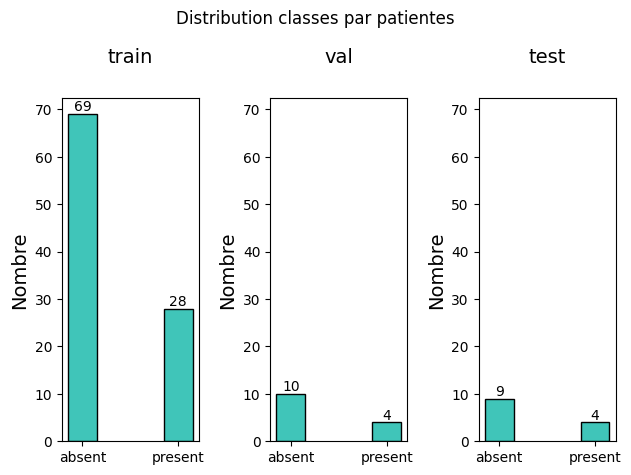

In [50]:
# Vérifier bonne distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train_patients['outcome'].map({0: 'absent', 1: 'present'}), shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val_patients['outcome'].map({0: 'absent', 1: 'present'}), shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test_patients['outcome'].map({0: 'absent', 1: 'present'}), shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes par patientes')
plt.tight_layout()
plt.show()

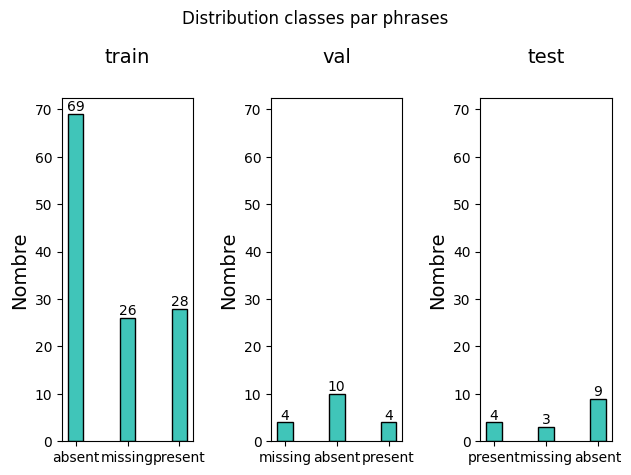

In [51]:
# Vérifier bonne distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes par phrases')
plt.tight_layout()
plt.show()

### Optional: Upsampling to correct class imbalance

In [54]:
train_original = train.copy()
train_negative = train.loc[train.outcome==0]
train_positive = train.loc[train.outcome==1]
train_missing = train.loc[train.outcome==2]

In [55]:
train_negative

,patient,text,outcome,str_outcome
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,0.0,absent
1,AB-067,rééducation vesico périnéale pour iu mixte hyp...,0.0,absent
8,AS-121,vue ce jour pour 1 utilisation de l urostim 2 ...,0.0,absent
10,BA-091,ecbu 2 01 10 5 pseudomonas et enterococcus f...,0.0,absent
12,BA-169,sp post opus avancé car douleurs pelviennes a ...,0.0,absent
...,...,...,...,...
141,TC-195,mail de la patiente bonjour je suis étonnée ...,0.0,absent
145,VA-139,mail de la patiente pour fortes douleurs suite...,0.0,absent
147,VH-014,appel ce jour pour faire un point après 15 jou...,0.0,absent
150,VP-008,irm 23 10 adénomyose diffuse prédominant en po...,0.0,absent


Number of samples in the minority class: 43
Number of samples in the majority class: 69
Number of samples in total now, before upsampling: 112
Number of samples it add to minority class: 26
Number of samples to be obtained in total after upsampling: 138


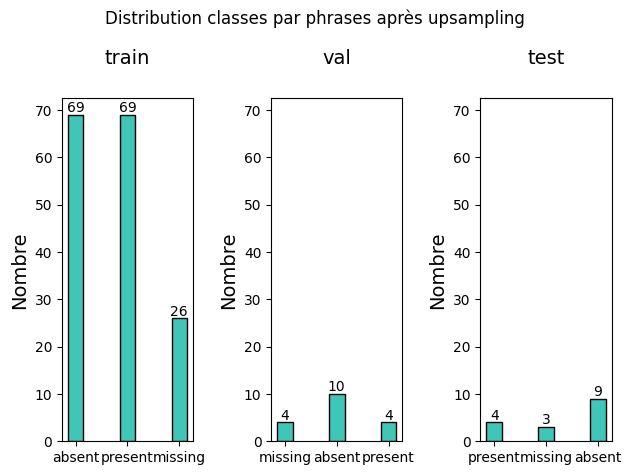

In [68]:
use_upsampling = True

if use_upsampling:

    ### Add more samples to the minority class by dubplicating the last N samples for each patient

    train_original = train.copy()
    train_negative = train.loc[train.outcome==0]
    train_positive = train.loc[train.outcome==1]
    train_missing = train.loc[train.outcome==2]

    if train_negative.shape[0] > train_positive.shape[0]:
        data_train_majority = train_negative
        data_train_minority = train_positive
    else:
        data_train_majority = train_positive
        data_train_minority = train_negative

    nsamples_minority = data_train_minority.shape[0]
    nsamples_majority = data_train_majority.shape[0]
    nsamples_total_before_upsampling = nsamples_majority+nsamples_minority
    nsamples_to_add = data_train_majority.shape[0] - data_train_minority.shape[0]
    
    # Upsample minority class
    data_train_minority_upsampled = resample(data_train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples= data_train_majority.shape[0],    # to match majority class
                                    random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    train_upsampled = pd.concat([data_train_majority, data_train_minority_upsampled, train_missing])

    bias = data_train_minority.shape[0]/data_train_majority.shape[0]
    nsamples_in_total_after_upsampling = nsamples_majority+nsamples_minority+nsamples_to_add
    print(f'Number of samples in the minority class: {nsamples_minority}')
    print(f'Number of samples in the majority class: {nsamples_majority}')
    print(f'Number of samples in total now, before upsampling: {nsamples_total_before_upsampling}')
    print(f'Number of samples it add to minority class: {nsamples_to_add}')
    print(f'Number of samples to be obtained in total after upsampling: {nsamples_in_total_after_upsampling}')

    '''
    npatients = len(pd.unique(train.patient))
    nsamples_to_add_per_patient = int(nsamples_to_add/npatients)
    train_upsampled = train.copy()
    patients = pd.unique(train.patient)
    for patient in patients:
        train_patient = data_train_minority.loc[data_train_minority.patient==patient]
        train_upsampled = pd.concat([train_upsampled, train_patient.tail(nsamples_to_add_per_patient)])
    print(f'Number of samples obtained so far by augmentation: {train_upsampled.shape[0]}')

    # The division by number of patients doesn't result in all samples to add being assigned.
    # Iterate through patients and add more samples one-by-one, until we have enough
    while train_upsampled.shape[0] < nsamples_in_total_after_upsampling:
        ipatient = 0
        while ipatient < len(patients):
            patient = patients[ipatient]
            train_patient = data_train_minority.loc[data_train_minority.patient==patient]
            train_upsampled = pd.concat([train_upsampled, train_patient.tail(1)])
            if train_upsampled.shape[0] == nsamples_in_total_after_upsampling:
                break
            ipatient += 1
    print(f'Number of samples obtained by augmentation finally: {train_upsampled.shape[0]}')
    '''
    train = train_upsampled.copy()

    # Vérifier bonne distribution des classes dans train/val/test
    fig, axs = plt.subplots(nrows=1, ncols=3)
    axs = axs.flatten()
    sns.histplot(data=train_upsampled['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[0])
    axs[0].bar_label(axs[0].containers[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Nombre', fontsize=14)
    axs[0].set_title('train', pad=25, fontsize=14)
    sns.histplot(data=val['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[1])
    axs[1].bar_label(axs[1].containers[0])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Nombre', fontsize=14)
    axs[1].set_ylim(axs[0].get_ylim())
    axs[1].set_title('val', pad=25, fontsize=14)
    sns.histplot(data=test['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[2])
    axs[2].bar_label(axs[2].containers[0])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('Nombre', fontsize=14)
    axs[2].set_ylim(axs[0].get_ylim())
    axs[2].set_title('test', pad=25, fontsize=14)
    plt.suptitle('Distribution classes par phrases après upsampling')
    plt.tight_layout()
    plt.show()

### Transformation to DataLoader format

In [18]:
# Transformer les données en format qui peut être lu dans les librairies 'HuggingFace'

max_length = 512

train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16,
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
test_dataloader = DataLoader(
    dataset["test"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)

## Training

In [19]:
learning_rate = 3e-5
# Choose loss function: Either 'crossentropyloss', 'weightedcrossentropyloss' or 'focalloss'
loss_function = 'crossentropyloss'
if use_upsampling and (loss_function != 'crossentropyloss'):
    raise ValueError('If you use upsampling, you need to use crossentropyloss')

# Calculate class weights
if loss_function == 'weightedcrossentropyloss':
    class_weights = compute_class_weight(class_weight="balanced", classes=pd.unique(train_original['outcome']), y=train_original['outcome'].values)  # Using train_original because in case upsampling is used as well, compute weights without taking duplicate samples into account
    class_weights = torch.tensor(class_weights,dtype=torch.float)
    print('Class weights:')
    print(class_weights)
else:
    class_weights = None

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=6, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [21]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, loss_function, class_weights = None, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        if loss_function == 'crossentropyloss':
            loss_fn = torch.nn.CrossEntropyLoss()
        elif loss_function == 'weightedcrossentropyloss':
            loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        elif loss_function == 'focalloss':
            loss_fn = FocalLoss()
        else:
            raise ValueError(f'Invalid loss function specified: {loss_function}')
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [22]:
target_feature_txt = target_feature.replace('.', '_')
txt_upsampling = '_upsampling' if use_upsampling else ''
model_checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="valid/acc", 
    mode="max",
    dirpath=model_dir,
    filename=f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}_{loss_function}{txt_upsampling}',
    save_top_k=1,
    save_weights_only=True
)

# Set up CSV logger
csv_logger = CSVLogger("logs", name="camembert_training")
camembert_trainer = pl.Trainer(
    max_epochs=20,
    #gpus=1,
    logger=csv_logger,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
lightning_model = LightningModel(pretrained_model, num_labels, lr=learning_rate, weight_decay=0., loss_function=loss_function, class_weights=class_weights)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\nwolpert\Documents\Dimedia\Endopaths\models exists and is not empty.

  | Name  | Type                               | Params | Mode
--------------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M  | eval
--------------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.494   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\nwolper

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [63]:
pickle.dump(camembert_trainer, open(model_dir + f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}_{loss_function}_{txt_upsampling}', 'wb'))

In [64]:
### Evaluate performance

# Load the best model checkpoint
best_model_path = model_checkpoint.best_model_path
best_model = LightningModel.load_from_checkpoint(best_model_path, model_name=pretrained_model, num_labels=num_labels, lr=3e-5, weight_decay=0.)

# Predict on the test dataset
predictions = []
true_labels = []

best_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    for batch in test_dataloader:
        preds = best_model.predict_step(batch, batch_idx=0).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.6000
Precision: 0.6003
Recall: 0.6011
F1 Score: 0.5993
Confusion Matrix:
[[46 29]
 [37 53]]


In [66]:
## Show performance by patient
# Merge predictions patient-wise (since we have several texts per patient), choosing the most frequent prediction

test.loc[:, 'predictions'] = predictions
predictions_per_patient_text = test.sort_values('patient', ascending=True).groupby('patient')['predictions'].value_counts()
predictions_by_patient_majority = []
for patient in pd.unique(test.patient):
    # In case the number of predictions for the classes are the same, assign most frequent outcome
    if (predictions_per_patient_text[patient].shape[0]==2) and (predictions_per_patient_text[patient].loc[0] == predictions_per_patient_text[patient].loc[1]):
        predictions_by_patient_majority = predictions_by_patient_majority + [test['outcome'].value_counts().nlargest(1).index[0]]
    else:
        predictions_by_patient_majority = predictions_by_patient_majority + [predictions_per_patient_text[patient].idxmax()]

true_classes_by_patient = list(test.drop_duplicates(subset='patient').sort_values('patient', ascending=True)['outcome'])

if len(predictions_by_patient_majority) != len(true_classes_by_patient):
    raise ValueError('Mismatch in the number of samples')
    
# Calculate evaluation metrics if the lengths match
accuracy_by_patient_majority = accuracy_score(true_classes_by_patient, predictions_by_patient_majority)
precision_by_patient_majority = precision_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
recall_by_patient_majority = recall_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
f1_by_patient_majority = f1_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
conf_matrix_by_patient_majority = confusion_matrix(true_classes_by_patient, predictions_by_patient_majority)

print('##### Performance patient-wise:')
print(f'Accuracy: {accuracy_by_patient_majority:.4f}')
print(f'Precision: {precision_by_patient_majority:.4f}')
print(f'Recall: {recall_by_patient_majority:.4f}')
print(f'F1 Score: {f1_by_patient_majority:.4f}')
print('Confusion Matrix:')
print(conf_matrix_by_patient_majority)

##### Performance patient-wise:
Accuracy: 0.7500
Precision: 0.7460
Recall: 0.7460
F1 Score: 0.7460
Confusion Matrix:
[[7 2]
 [2 5]]


C:\Users\nwolpert\AppData\Local\Temp\ipykernel_9056\819608798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predictions'] = predictions


## TO TEST:
- undersampling
- investigate correct and misclassifications

In [65]:
target_feature_txt = target_feature.replace('.', '_')
txt_wl = '_weighted_loss' if use_weighted_loss else ''
txt_upsampling = '_upsampling' if use_upsampling else ''
camembert_trainer = pickle.load(open(model_dir + f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}{txt_wl}{txt_upsampling}', 'rb'))

NameError: name 'use_weighted_loss' is not defined

In [ ]:
model_checkpoint

In [ ]:
### Evaluate performance

# Load the best model checkpoint
best_model_path = model_checkpoint.best_model_path
best_model = LightningModel.load_from_checkpoint(best_model_path, model_name=pretrained_model, num_labels=num_labels, lr=3e-5, weight_decay=0.)

# Predict on the test dataset
predictions = []
true_labels = []

best_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    for batch in test_dataloader:
        preds = best_model.predict_step(batch, batch_idx=0).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

PermissionError: [Errno 13] Permission denied: 'c:/Users/nwolpert/Documents/Dimedia/Endopaths/Code/endopaths'

In [ ]:
best_model_path

''

In [ ]:
import os
import pickle
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pytorch_lightning import LightningModule

# Function to load model checkpoint
def load_model_checkpoint(model_checkpoint_path, model_class, **kwargs):
    if not os.path.isfile(model_checkpoint_path):
        raise FileNotFoundError(f"Model checkpoint not found: {model_checkpoint_path}")
    
    try:
        model = model_class.load_from_checkpoint(model_checkpoint_path, **kwargs)
    except PermissionError as e:
        print(f"Permission error encountered while loading the model: {e}")
        raise
    return model

# Example model directory and other variables
model_dir = 'c:/Users/nwolpert/Documents/Dimedia/Endopaths/Code/endopaths/'
pretrained_model = 'camembert-base'
target_feature_txt = target_feature.replace('.', '_')
txt_wl = '_weighted_loss' if use_weighted_loss else ''
txt_upsampling = '_upsampling' if use_upsampling else ''
model_checkpoint_path = model_dir + f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}{txt_wl}{txt_upsampling}'

# Debug: Print the model checkpoint path
print(f"Model checkpoint path: {model_checkpoint_path}")

# Check if the file exists
if not os.path.isfile(model_checkpoint_path):
    print(f"File not found: {model_checkpoint_path}")

# Load the model checkpoint object
try:
    with open(model_checkpoint_path, 'rb') as f:
        model_checkpoint = pickle.load(f)
except Exception as e:
    print(f"Error loading model checkpoint: {e}")

# Debug: Inspect the model checkpoint object
print(f"Model checkpoint object: {model_checkpoint}")

# Debug: Check if best_model_path is in model_checkpoint
if hasattr(model_checkpoint, 'best_model_path'):
    best_model_path = model_checkpoint.best_model_path
    print(f"Best model path from checkpoint: {best_model_path}")
else:
    print("best_model_path attribute not found in model_checkpoint")
    # Set a fallback path if necessary
    best_model_path = 'path/to/default/checkpoint.ckpt'

# Ensure best_model_path is not empty
if not best_model_path:
    raise ValueError("Best model path is empty. Please provide a valid path.")

# Load the best model checkpoint
best_model = load_model_checkpoint(best_model_path, LightningModel, model_name=pretrained_model, num_labels=num_labels, lr=3e-5, weight_decay=0.)

# Predict on the test dataset
predictions = []
true_labels = []

best_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    for batch in test_dataloader:
        preds = best_model.predict_step(batch, batch_idx=0).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Model checkpoint path: c:/Users/nwolpert/Documents/Dimedia/Endopaths/Code/endopaths/camembert-base_atcd_endo_split_patientwise_learning_rate_3e-05_weighted_loss_upsampling
File not found: c:/Users/nwolpert/Documents/Dimedia/Endopaths/Code/endopaths/camembert-base_atcd_endo_split_patientwise_learning_rate_3e-05_weighted_loss_upsampling
Error loading model checkpoint: [Errno 2] No such file or directory: 'c:/Users/nwolpert/Documents/Dimedia/Endopaths/Code/endopaths/camembert-base_atcd_endo_split_patientwise_learning_rate_3e-05_weighted_loss_upsampling'
Model checkpoint object: <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x0000023F60335D20>
Best model path from checkpoint: 


ValueError: Best model path is empty. Please provide a valid path.

In [ ]:
type(model_checkpoint.best_model_score)

NoneType

In [ ]:
model_checkpoint

In [ ]:
best_model_path

''